In [1]:
!pip install datasets==2.15 >/dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.3.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.1.4 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2024.1.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2024.1.0 which is incompatible.
dask-cuda 23.8.0 require

In [2]:
import numpy as np 
import pandas as pd 
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from datasets import load_dataset

dataset = load_dataset("MonoHime/ru_sentiment_dataset")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating validation split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


In [4]:
dataset.keys()

dict_keys(['train', 'validation'])

In [5]:
df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()

In [6]:
df_all = pd.concat([df_train, df_val], ignore_index=True)


# EDA

In [7]:
df_all.head(10)

,Unnamed: 0,text,sentiment
0,21098,".с.,и спросил его: о Посланник Аллаха!Ты пори...",1
1,21099,Роднее всех родных Попала я в ГКБ №8 еще в дек...,1
2,21100,Непорядочное отношение к своим работникам Рабо...,2
3,21101,"). Отсутствуют нормативы, Госты и прочее, что ...",1
4,21102,У меня машина в руках 5 лет и это п...,1
5,21103,Самое лучшее в отеле - место его расположения ...,0
6,21104,Дорогая аптека Дорогая аптека. В других сетях ...,1
7,21105,Останавливались с женой на годовщину. Отель по...,1
8,21106,"Персонал вежливый, все сделали аккуратно В цел...",1
9,21107,Второй раз останавливаюсь в этом отеле. С перв...,0


In [8]:
df_all.drop('Unnamed: 0',axis=1,inplace=True)
df_all.head(10)

,text,sentiment
0,".с.,и спросил его: о Посланник Аллаха!Ты пори...",1
1,Роднее всех родных Попала я в ГКБ №8 еще в дек...,1
2,Непорядочное отношение к своим работникам Рабо...,2
3,"). Отсутствуют нормативы, Госты и прочее, что ...",1
4,У меня машина в руках 5 лет и это п...,1
5,Самое лучшее в отеле - место его расположения ...,0
6,Дорогая аптека Дорогая аптека. В других сетях ...,1
7,Останавливались с женой на годовщину. Отель по...,1
8,"Персонал вежливый, все сделали аккуратно В цел...",1
9,Второй раз останавливаюсь в этом отеле. С перв...,0


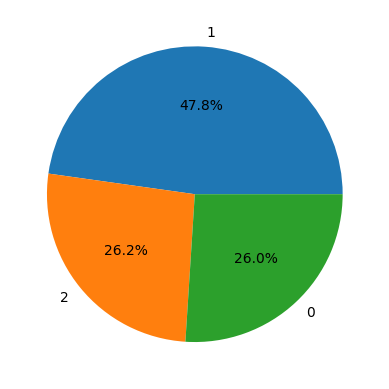

In [9]:
plt.pie(df_all['sentiment'].value_counts(), labels=df_all['sentiment'].unique().tolist(), autopct='%1.1f%%')
plt.show()

In [10]:
df_all[df_all['sentiment'] == 2].head(10)

,text,sentiment
2,Непорядочное отношение к своим работникам Рабо...,2
10,"Обходите стороной Кривошееву Добрый день, я та...",2
14,Верно! Анафема гоблядям!,2
22,Некомпетентный персонал на телефоне Поразитель...,2
28,Работа Международного центра приграничного со...,2
40,Принцип работы брендовой клиники Сегодня была ...,2
50,Аптеки открывают новые Аптек открывают - все б...,2
53,Узист Сколько раз я делала фолликулометрию у р...,2
54,Неадекватное поведение 13.12.2011 пришла на пл...,2
56,В шоке была от этого врача Я в шоке была от эт...,2


0 положительный \
1 нетральный \
2 отрицательный 

In [11]:
df_all['len'] = df_all['text'].str.len()
df_all['len'].describe()

count    210989.000000
mean        803.949599
std        2034.547401
min           3.000000
25%         278.000000
50%         504.000000
75%         911.000000
max      381498.000000
Name: len, dtype: float64

In [12]:
df_all['count_words'] = df_all['text'].str.split().apply(len)
df_all['count_words'].describe()

count    210989.000000
mean        120.733090
std         267.694719
min           1.000000
25%          41.000000
50%          76.000000
75%         139.000000
max       48146.000000
Name: count_words, dtype: float64

In [13]:
!pip install jupyter pandarallel tqdm >/dev/null

In [14]:
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [16]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words('russian')) # общей объект для чтения и параллельной работы 
def tokenize_and_delete_stopwords_and_stemming(text):
    text = text.lower()
    text = re.sub('[^а-я А-Я 0-9-]+', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_words = [stemmer.stem(word) for word in filtered_tokens]
    return stemmed_words

In [17]:
df_all['token_del_stopwords_and_stemming'] = df_all['text'].parallel_apply(tokenize_and_delete_stopwords_and_stemming)
df_all['count_words_del_stopwords'] = df_all['token_del_stopwords_and_stemming'].parallel_apply(len)
df_all['count_words_del_stopwords'].describe()

count    210989.00000
mean         78.35690
std         200.59501
min           0.00000
25%          28.00000
50%          49.00000
75%          88.00000
max       37432.00000
Name: count_words_del_stopwords, dtype: float64

на kaggle только два ядра есть

Видим уменьшение размера предложения в среднем на 40 слов

In [18]:
!python -m spacy download ru_core_news_md >/dev/null

In [19]:
import spacy
from spacy.lang.ru.examples import sentences
nlp = spacy.load("ru_core_news_md") # не совсем правильно ее использовать, так как она обучена на новостях   

def tokenize_and_delete_stopwords_and_lemma(text):
    text = text.lower()
    text = re.sub('[^а-я А-Я 0-9-]+', '', text)
    tokens = nlp(text)
    lemms = [token.lemma_ for token in tokens if not token.is_stop]
    return lemms

In [20]:
df_part = pd.DataFrame()
random_permutation = np.random.permutation(len(df_all))[:1000]
df_part['token_del_stopwords_and_lemma'] = df_all['text'][random_permutation].progress_apply(tokenize_and_delete_stopwords_and_lemma)
# там сетка уже на нескольких ядрах не получиться многопроццесов сделать 
df_part['count_words_del_stopwords_spacy'] = df_part['token_del_stopwords_and_lemma'].parallel_apply(len)
df_part['count_words_del_stopwords_spacy'].describe()

100%|██████████| 1000/1000 [01:28<00:00, 11.24it/s]


count    1000.000000
mean       79.081000
std       130.095593
min         2.000000
25%        27.000000
50%        48.000000
75%        84.000000
max      1925.000000
Name: count_words_del_stopwords_spacy, dtype: float64

Взял маленькую выборку, так как не хватает производительности \
результаты не сильно отличаются по сравнению с nltk \
Выделяться std и max, но это можно списать на то, что в выборку не попали выбросы 
  


In [21]:
def len_words(text):
    text_split = text.split()
    len_text  = len(text) if len(text)!=0 else 1
    return sum(map(len,text_split))/len_text
def len_words_without_stopword(text):
    len_text = len(text) if len(text)!=0 else 1

    return sum(map(len,text))/len_text

In [22]:
df_all['len_words'] = df_all['text'].parallel_apply(len_words)
df_all['len_words'].describe()

count    210989.000000
mean          0.845573
std           0.021427
min           0.333333
25%           0.834646
50%           0.847826
75%           0.859375
max           1.000000
Name: len_words, dtype: float64

видем явный выбросс 

In [23]:
df_all['len_words_without_stopword'] = df_all['token_del_stopwords_and_stemming'].parallel_apply(len_words_without_stopword)
df_all['len_words_without_stopword'].describe()

count    210989.000000
mean          5.598639
std           3.467585
min           0.000000
25%           5.191489
50%           5.523810
75%           5.918919
max        1096.333333
Name: len_words_without_stopword, dtype: float64

In [24]:
df_all['sentiment'].head()

0    1
1    1
2    2
3    1
4    1
Name: sentiment, dtype: int64

In [25]:
def visualize(col):
    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=df_all[col], hue=df_all['sentiment'])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.kdeplot(df_all,x=col, hue='sentiment')
    plt.legend(df_all['sentiment'].unique())
    plt.xlabel(col)
    plt.ylabel('')
    
    plt.show()

In [26]:
df_all.columns

Index(['text', 'sentiment', 'len', 'count_words',
       'token_del_stopwords_and_stemming', 'count_words_del_stopwords',
       'len_words', 'len_words_without_stopword'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


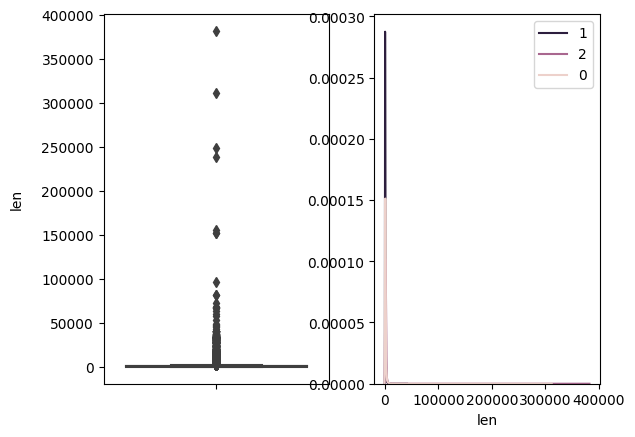

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


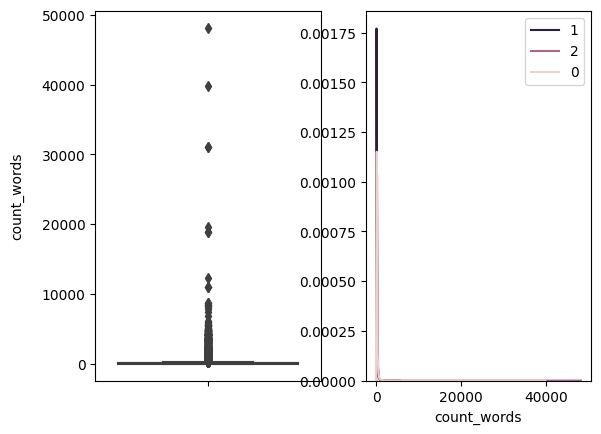

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


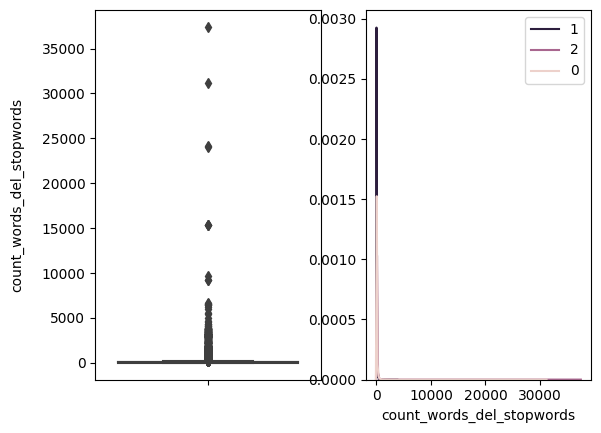

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


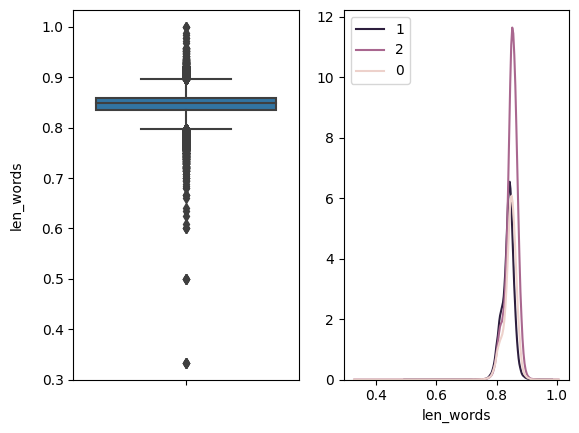

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


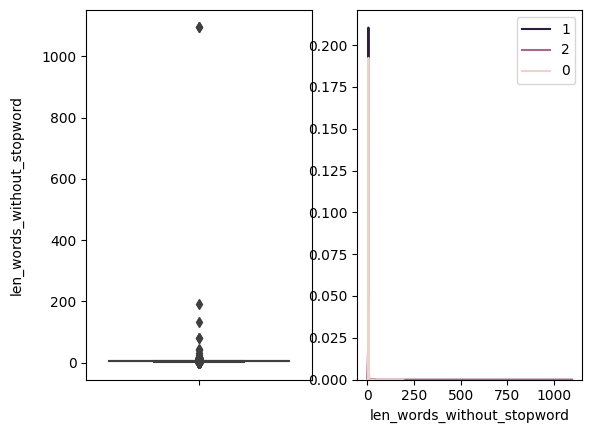

In [27]:
features = [
    'len',
    'count_words',
    'count_words_del_stopwords',
    'len_words',
    'len_words_without_stopword']
for feature in features:
    visualize(feature)

логарифмирование

In [28]:
def visualize_log(col):
    print(col)
    
    sns.kdeplot(df_all,x=col, hue='sentiment',log_scale=True)
    plt.legend(df_all['sentiment'].unique())
    plt.xlabel(col)
    plt.ylabel('')
    
    plt.show()

len


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


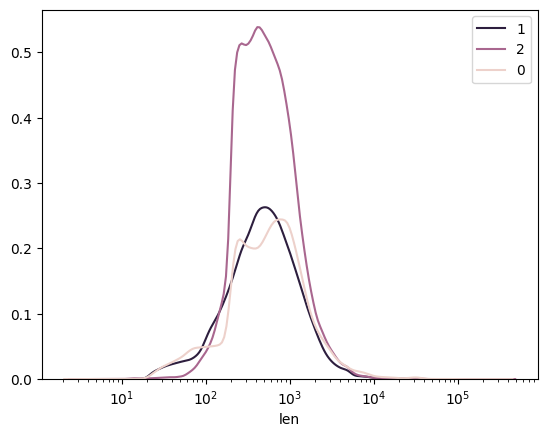

count_words


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


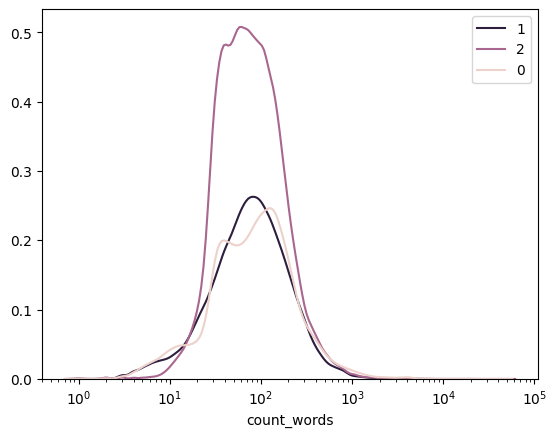

count_words_del_stopwords


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/tmp/ipykernel_34/774170404.py:4: UserWarning: Dataset has 0 variance; skipping densi

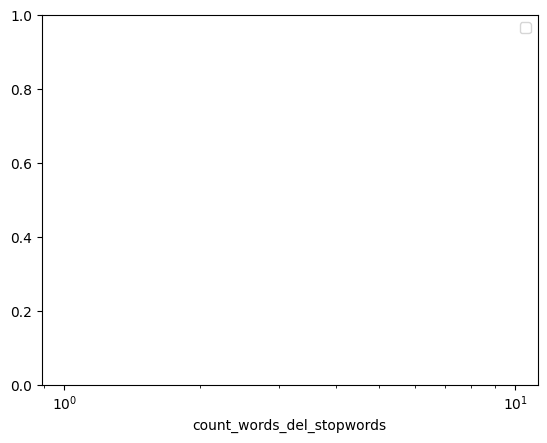

len_words


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


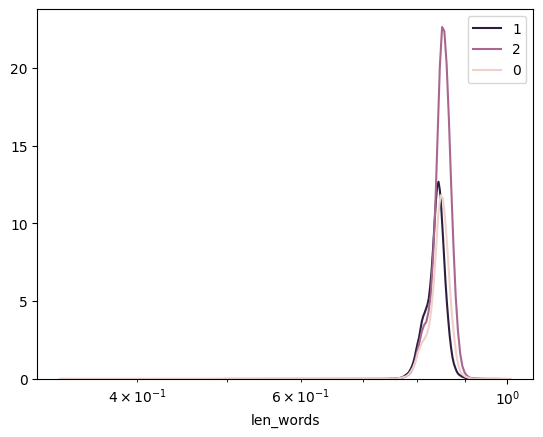

len_words_without_stopword


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/tmp/ipykernel_34/774170404.py:4: UserWarning: Dataset has 0 variance; skipping densi

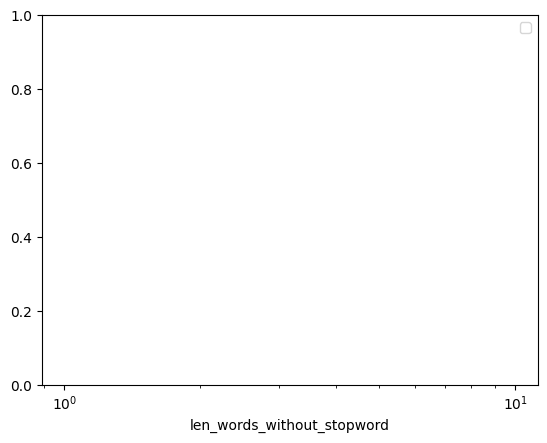

In [29]:
features = [
    'len',
    'count_words',
    'count_words_del_stopwords',
    'len_words',
    'len_words_without_stopword']
for feature in features:
    visualize_log(feature)

Посмотрим на самые популярные токены

In [30]:
import itertools
from collections import Counter
totals = Counter(i for i in itertools.chain.from_iterable(df_all['token_del_stopwords_and_stemming']))
totals.most_common(20)

[('-', 233516),
 ('эт', 167604),
 ('очен', 155543),
 ('отел', 111572),
 ('котор', 86531),
 ('номер', 85907),
 ('врач', 85862),
 ('год', 74913),
 ('так', 61751),
 ('сам', 61117),
 ('сво', 58441),
 ('хорош', 55278),
 ('спасиб', 50806),
 ('прост', 49570),
 ('больш', 45007),
 ('сказа', 42990),
 ('наш', 42341),
 ('мест', 39087),
 ('одн', 39084),
 ('друг', 37743)]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


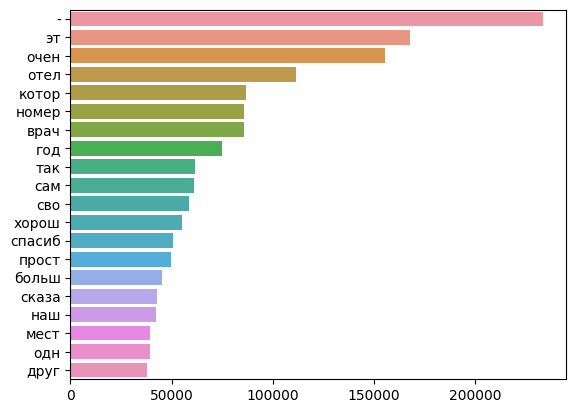

In [31]:
words = []
freq = []
for word, count in totals.most_common(20):
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.show()

Разделем по классам

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


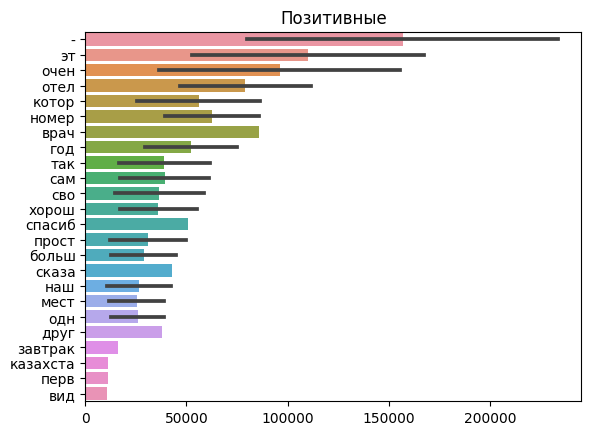

In [32]:
totals = Counter(i for i in itertools.chain.from_iterable(
    df_all[df_all["sentiment"]==0]['token_del_stopwords_and_stemming'])
                )
for word, count in totals.most_common(20):
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Позитивные')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


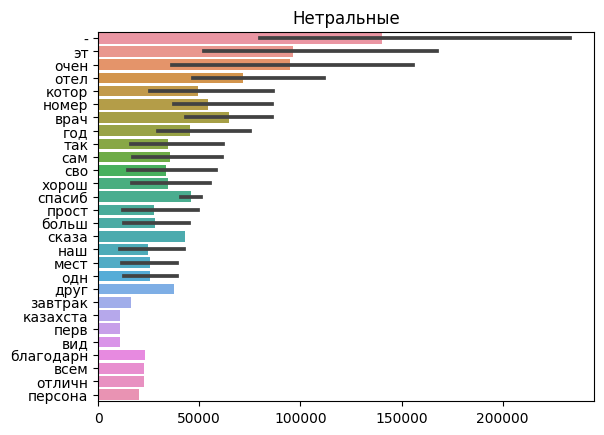

In [33]:
totals = Counter(i for i in itertools.chain.from_iterable(
    df_all[df_all["sentiment"]==1]['token_del_stopwords_and_stemming'])
                )
for word, count in totals.most_common(20):
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Нетральные')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


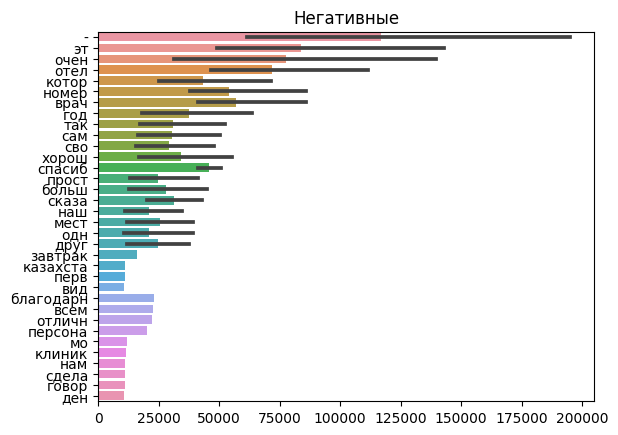

In [34]:
totals = Counter(i for i in itertools.chain.from_iterable(
    df_all[df_all["sentiment"]==2]['token_del_stopwords_and_stemming'])
                )
for word, count in totals.most_common(20):
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Негативные')
plt.show()

# тематическое моделирование текстовых данных

LDA

In [35]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [36]:
def prepare(text):
    text = text.lower()
    text = re.sub('[^а-я А-Я 0-9-]+', '', text)
    return text
df_all['prepare'] = df_all['text'].parallel_apply(prepare)

In [37]:
stop_words = set(STOPWORDS)
texts = [[word for word in simple_preprocess(doc) if word not in stop_words] for doc in df_all['prepare']]
dictionary = corpora.Dictionary(texts)

In [38]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [39]:
random_permutation_corpus = np.random.permutation(len(df_all))[:10000]

texts_part = [[word for word in simple_preprocess(doc) if word not in stop_words] for doc in df_all['prepare'][random_permutation_corpus]]
dictionary_part = corpora.Dictionary(texts_part)
corpus_part = [dictionary_part.doc2bow(text) for text in texts_part]

In [40]:
num_topics = 5
lda_model5 = LdaModel(corpus_part, num_topics=num_topics, id2word=dictionary_part, passes=4)
num_topics = 10
lda_model10 = LdaModel(corpus_part, num_topics=num_topics, id2word=dictionary_part, passes=4)

num_topics = 4
lda_model4 = LdaModel(corpus_part, num_topics=num_topics, id2word=dictionary_part, passes=4)
num_topics = 3
lda_model3 = LdaModel(corpus_part, num_topics=num_topics, id2word=dictionary_part, passes=4)
num_topics = 20
lda_model20 = LdaModel(corpus_part, num_topics=num_topics, id2word=dictionary_part, passes=4)


In [41]:
from gensim.models import CoherenceModel

In [42]:
for i in ['u_mass']:
    cm20 = CoherenceModel(model=lda_model20, corpus=corpus_part, coherence=i)
    print(i,20,cm20.get_coherence())
    cm10 = CoherenceModel(model=lda_model10, corpus=corpus_part, coherence=i)
    print(i,10,cm10.get_coherence())
    cm5 = CoherenceModel(model=lda_model5, corpus=corpus_part, coherence=i)
    print(i,5,cm5.get_coherence())
    cm4 = CoherenceModel(model=lda_model4, corpus=corpus_part, coherence=i)
    print(i,4,cm4.get_coherence())
    cm3 = CoherenceModel(model=lda_model3, corpus=corpus_part, coherence=i)
    print(i,3,cm3.get_coherence())

u_mass 20 -10.191705690293803
u_mass 10 -7.1506619113315635
u_mass 5 -3.3528793597067286
u_mass 4 -1.414834142651261
u_mass 3 -1.369893578531616


модель на 4 темы самая лучшия по когерентность 

In [43]:
for idx, topic in lda_model4.print_topics(-1):
    print(f"Тема {idx + 1}: {topic}")

Тема 1: 0.033*"не" + 0.021*"на" + 0.021*"что" + 0.009*"это" + 0.008*"как" + 0.008*"то" + 0.007*"по" + 0.007*"все" + 0.006*"за" + 0.006*"мне"
Тема 2: 0.025*"не" + 0.023*"на" + 0.012*"очень" + 0.012*"что" + 0.011*"но" + 0.009*"все" + 0.007*"по" + 0.007*"это" + 0.006*"как" + 0.006*"то"
Тема 3: 0.018*"на" + 0.015*"по" + 0.006*"года" + 0.005*"тенге" + 0.005*"для" + 0.004*"что" + 0.004*"за" + 0.004*"из" + 0.004*"году" + 0.003*"ао"
Тема 4: 0.024*"спасибо" + 0.014*"за" + 0.012*"благодарность" + 0.008*"очень" + 0.007*"хочу" + 0.007*"вам" + 0.007*"огромное" + 0.004*"всем" + 0.004*"большое" + 0.004*"отношение"


NMF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

documents = list(map(lambda x: " ".join(x),df_all['token_del_stopwords_and_stemming']))
vectorizer = TfidfVectorizer(max_features=1000)
vectorize_tokens = vectorizer.fit_transform(documents)

num_topics = 4
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(vectorize_tokens)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic_words in enumerate(nmf.components_):
    top_words_idx = topic_words.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Тема {topic_idx + 1}: {', '.join(top_words)}")

Тема 1: отел, номер, завтрак, очен, хорош, чист, метр, удобн, ряд, персона
Тема 2: эт, котор, так, год, сво, сам, прост, друг, одн, говор
Тема 3: врач, спасиб, благодарн, клиник, отделен, огромн, доктор, хоч, лечен, зуб
Тема 4: очен, вкусн, рестора, понрав, кухн, обслуживан, приятн, ресторан, блюд, спасиб


In [45]:
num_topics = 5
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(vectorize_tokens)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic_words in enumerate(nmf.components_):
    top_words_idx = topic_words.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Тема {topic_idx + 1}: {', '.join(top_words)}")

Тема 1: отел, номер, завтрак, очен, чист, хорош, метр, удобн, ряд, персона
Тема 2: эт, котор, так, год, сво, сам, прост, машин, друг, одн
Тема 3: спасиб, благодарн, отделен, огромн, хоч, всем, доктор, выраз, внимательн, сотрудник
Тема 4: очен, вкусн, рестора, понрав, кухн, обслуживан, приятн, ресторан, блюд, интерьер
Тема 5: врач, клиник, зуб, лечен, леч, поликлиник, анализ, сказа, очен, ребенк


In [46]:
num_topics = 3
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(vectorize_tokens)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic_words in enumerate(nmf.components_):
    top_words_idx = topic_words.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Тема {topic_idx + 1}: {', '.join(top_words)}")

Тема 1: отел, номер, очен, завтрак, хорош, персона, чист, удобн, отличн, метр
Тема 2: эт, так, котор, прост, год, сам, сво, очен, мест, друг
Тема 3: врач, спасиб, благодарн, клиник, отделен, огромн, доктор, очен, хоч, лечен


In [47]:
num_topics = 5
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(vectorize_tokens)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic_words in enumerate(nmf.components_):
    top_words_idx = topic_words.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Тема {topic_idx + 1}: {', '.join(top_words)}")

Тема 1: отел, номер, завтрак, очен, чист, хорош, метр, удобн, ряд, персона
Тема 2: эт, котор, так, год, сво, сам, прост, машин, друг, одн
Тема 3: спасиб, благодарн, отделен, огромн, хоч, всем, доктор, выраз, внимательн, сотрудник
Тема 4: очен, вкусн, рестора, понрав, кухн, обслуживан, приятн, ресторан, блюд, интерьер
Тема 5: врач, клиник, зуб, лечен, леч, поликлиник, анализ, сказа, очен, ребенк


LSI

In [48]:
from gensim.models import LsiModel
lsi_models=[]
for i in [3,4,5,6,10]:
    lsi_models.append(LsiModel(corpus_part, id2word=dictionary, num_topics=i))
    cm = CoherenceModel(model=lsi_models[-1], corpus=corpus_part, coherence='u_mass')
    print(i,cm.get_coherence())

3 -1.1862365126502656
4 -2.03619005235692
5 -1.8155208779936505
6 -1.6744023937350834
10 -2.2212129287286264


In [49]:
for idx, topic in lsi_models[0].print_topics(-1):
    print(f"Тема {idx + 1}: {topic}")

Тема 1: 0.527*"ауситы" + 0.470*"благословит" + 0.305*"повернулся" + 0.246*"сказать" + 0.148*"поисках" + 0.139*"ко" + 0.135*"буас" + 0.133*"аллаха" + 0.125*"абу" + 0.124*"постельное"
Тема 2: 0.468*"благословит" + -0.340*"сказать" + -0.332*"ауситы" + 0.224*"повернулся" + -0.202*"безвкусной" + -0.180*"самолета" + -0.152*"будто" + -0.139*"холле" + -0.136*"сдавала" + 0.128*"буас"
Тема 3: -1.000*"терпение" + -0.009*"палата" + -0.006*"сказать" + 0.006*"благословит" + -0.006*"пенсии" + -0.006*"мотивируя" + -0.006*"вынести" + -0.003*"гормоны" + -0.003*"представляется" + -0.003*"переводили"


Можно использовать razdel от Natasha для более хороших результатов \
не особо разбираюсь в тематическом моделирование, не сталкивался с этой задачей до этого \
Репозиторий natasha нашел только на этом этапе 

In [50]:
!pip install razdel >/dev/null

In [51]:
!pip install navec >/dev/null

# Обучение классификатора
начнем с classic ml

In [52]:
# random_permutation = np.random.permutation(len(df_all))[:10000]
X = df_all['token_del_stopwords_and_stemming']#[random_permutation]
Y = df_all['sentiment']#[random_permutation]
# 210989

много данных долго обучать \
буду использовать всего 5 процентов 

In [53]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test =train_test_split(
    X,
    Y,
    random_state=42,
    test_size=0.95,
    stratify=Y
)
x_val,x_test, y_val, y_test =train_test_split(
    x_test,
    y_test,
    random_state=42,
    test_size=0.8,
    stratify=y_test
)

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [55]:
vectorizer = TfidfVectorizer(max_features=1000)

x_train_vectors = list(map(lambda x: " ".join(x),x_train))
x_train_vectors = vectorizer.fit_transform(x_train_vectors)

x_test_vectors = list(map(lambda x: " ".join(x),x_test))
x_test_vectors = vectorizer.transform(x_test_vectors)

x_val_vectors = list(map(lambda x: " ".join(x),x_val))
x_val_vectors = vectorizer.transform(x_val_vectors)

In [56]:
x_train_vectors = x_train_vectors.toarray()
x_test_vectors = x_test_vectors.toarray()
x_val_vectors = x_val_vectors.toarray()

классы не сбалансированы будем использовать f1(macro), чтобы понять что классификатор в общем работает

In [57]:
metrics_test ={}

In [58]:
from sklearn.metrics import f1_score
nb = GaussianNB()
nb.fit(x_train_vectors, y_train)
y_pred = nb.predict(x_test_vectors)
metrics_test['GaussianNB'] = f1_score(y_test, y_pred,average='macro'), {}
metrics_test['GaussianNB']

(0.5783193028307135, {})

можно запустить поиск еще и для tfidf, но это долго, и нужно если что-то весомое получим

In [59]:
SEED = 42
def objective_svc(trial):
    params = {
        "C": trial.suggest_float('C', 0.5, 5),
        "decision_function_shape": trial.suggest_categorical("decision_function_shape", ['ovo', 'ovr']) ,
        "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid' ]),
    }
    if params['kernel'] =='poly':
        params['degree'] = trial.suggest_int('degree',2,10)
    clf = SVC(random_state=SEED, **params)
    clf.fit(x_train_vectors, y_train)
    y_pred = clf.predict(x_val_vectors)
    f1 = f1_score(y_val, y_pred,average='macro')
#     print(params,"\n",f1)

    return f1

In [60]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_svc, n_trials=10, timeout=200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)


Number of finished trials: 2
  Value: 0.6576878129834212
{'C': 1.3627145907256504, 'decision_function_shape': 'ovr', 'kernel': 'sigmoid'}


тут я просто показываю как обучение проходит, и что я могу пользоваться optuna \
не же ли реально обучаю(не так интересно, хочу dl попробовать)

In [62]:
params = {
        "C": 1.3627145907256504,
        "decision_function_shape": 'ovr' ,
        "kernel": "sigmoid",
}
svc = SVC(random_state=SEED, **params)
svc.fit(x_train_vectors, y_train)
y_pred = svc.predict(x_test_vectors)
metrics_test['SVC'] = f1_score(y_test, y_pred,average='macro'), params
metrics_test['SVC']

(0.6576758385416883,
 {'C': 1.3627145907256504,
  'decision_function_shape': 'ovr',
  'kernel': 'sigmoid'})

In [63]:
!pip install slovnet >/dev/null

In [64]:
!wget "https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar" >/dev/null

--2024-02-19 10:25:10--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: 'navec_hudlit_v1_12B_500K_300d_100q.tar'

navec_hudlit_v1_12B 100%[===================>]  50.56M  17.9MB/s    in 2.8s    

2024-02-19 10:25:14 (17.9 MB/s) - 'navec_hudlit_v1_12B_500K_300d_100q.tar' saved [53012480/53012480]



In [65]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

from navec import Navec
from slovnet.model.emb import NavecEmbedding
from sklearn.utils.class_weight import compute_class_weight

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
stop_words = set(stopwords.words("russian"))
navec = Navec.load("./navec_hudlit_v1_12B_500K_300d_100q.tar")


def clean(text):
    text = text.lower()
    text = re.sub(r"[^а-яА-Я]+", " ", text)
    text = re.sub(r"\s+", " ", text)

    return " ".join([token for token in text.split() if token not in stop_words])


def token2idx(text):
    return [navec.vocab.get(token, navec.vocab.unk_id) for token in text.split()]


def padding(sequences, max_len: int = 256):
    features = np.zeros((len(sequences), max_len), dtype=np.int64)

    for i, seq in enumerate(sequences):
        if len(seq) <= max_len:
            zeros = list(np.full((max_len - len(seq)), navec.vocab.pad_id))
            new = zeros + seq
        else:
            new = seq[:max_len]

        features[i, :] = np.array(new)

    return features



In [68]:
# import torch
import torch.nn as nn
from navec import Navec
from slovnet.model.emb import NavecEmbedding


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_size = 256
        drp = 0.1
        self.embedding = NavecEmbedding(navec)
        self.lstm = nn.LSTM(
            300, 
            hidden_size=self.hidden_size, 
            num_layers=3,
            batch_first=True,
            dropout=.4,
        )
        self.linear = nn.Linear(
            self.hidden_size * 2, 
            64
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, 3)

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [89]:
model = Net()
model.to(device)


Net(
  (embedding): NavecEmbedding(id='hudlit_v1_12B_500K_300d_100q', indexes=[...], codes=[...])
  (lstm): LSTM(300, 256, num_layers=3, batch_first=True, dropout=0.4)
  (linear): Linear(in_features=512, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=3, bias=True)
)

In [87]:
epochs = 15
batch_size = 512


In [71]:
X = df_all['text'].parallel_apply(clean).tolist()

In [72]:
x_train,x_test, y_train, y_test =train_test_split(
    X,
    Y,
    random_state=42,
    test_size=0.95,
    stratify=Y
)
x_val,x_test, y_val, y_test =train_test_split(
    x_test,
    y_test,
    random_state=42,
    test_size=0.8,
    stratify=y_test
)

In [73]:
x_train_prep = [token2idx(text) for text in x_train]
x_val_prep = [token2idx(text) for text in x_val]
x_test_prep = [token2idx(text) for text in x_test]

In [74]:
x_train_prep = torch.from_numpy(padding(x_train_prep, 1024))
x_val_prep = torch.from_numpy(padding(x_val_prep, 1024))
x_test_prep = torch.from_numpy(padding(x_test_prep, 1024))

In [75]:
y_train = torch.from_numpy(y_train.to_numpy())
y_val = torch.from_numpy(y_val.to_numpy())
y_test = torch.from_numpy(y_test.to_numpy())

In [92]:
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
)
criterion = torch.nn.CrossEntropyLoss()

In [90]:


train_dataset = TensorDataset(
    x_train_prep,
    y_train,
)

val_dataset = TensorDataset(
    x_val_prep,
    y_val,
)

test_dataset = TensorDataset(
    x_test_prep,
    y_test
)


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)


val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [78]:
!pip install torcheval >/dev/null

In [79]:
from torcheval.metrics.functional import multiclass_f1_score

In [93]:
result_f1_train =[]
result_f1_val =[]
result_loss_train = []
result_loss_val = []
for epoch in range(epochs):
    avg_loss = 0.0
    avg_f1 = []
    softmax = nn.Softmax(dim=1)
    
    model.train()
    
    for i, (x_batch, y_batch) in enumerate(train_loader, 1):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch.long())
        loss = criterion(y_pred, y_batch)
        avg_loss += loss.item()
        avg_f1.append(multiclass_f1_score(softmax(y_pred),y_batch,num_classes=3,average='macro'))
        loss.backward()
        optimizer.step()
    
    result_loss_train.append(avg_loss / (len(train_loader.dataset) // batch_size))
    result_f1_train.append(sum(avg_f1)/len(avg_f1))
    avg_f1=[]
    print(
        f"[Epoch {epoch + 1}] [Train] loss: {result_loss_train[-1]:.3f} f1: {result_f1_train[-1]:.3f}",
        end= " "
    )

    model.eval()

    avg_val_loss = .0

    for i, (x_batch, y_batch) in enumerate(val_loader, 1):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch.long())
        loss = criterion(y_pred, y_batch)
        avg_f1.append(multiclass_f1_score(softmax(y_pred),y_batch,num_classes=3,average='macro'))

        avg_val_loss += loss.item()
    result_loss_val.append(avg_val_loss / (len(val_loader.dataset) // batch_size))
    result_f1_val.append(sum(avg_f1)/len(avg_f1))
    avg_f1=[]
    print(
        f"[Val] loss: {result_loss_val[-1]:.3f} f1: {result_f1_val[-1]:.3f}"
    )

[Epoch 1] [Train] loss: 1.167 f1: 0.139 [Val] loss: 1.117 f1: 0.139
[Epoch 2] [Train] loss: 1.138 f1: 0.195 [Val] loss: 1.066 f1: 0.215
[Epoch 3] [Train] loss: 1.105 f1: 0.215 [Val] loss: 1.059 f1: 0.215
[Epoch 4] [Train] loss: 1.087 f1: 0.215 [Val] loss: 1.022 f1: 0.215
[Epoch 5] [Train] loss: 1.028 f1: 0.215 [Val] loss: 0.982 f1: 0.215
[Epoch 6] [Train] loss: 1.009 f1: 0.284 [Val] loss: 0.973 f1: 0.415
[Epoch 7] [Train] loss: 0.993 f1: 0.327 [Val] loss: 0.948 f1: 0.411
[Epoch 8] [Train] loss: 0.970 f1: 0.405 [Val] loss: 0.921 f1: 0.422
[Epoch 9] [Train] loss: 0.930 f1: 0.468 [Val] loss: 0.883 f1: 0.525
[Epoch 10] [Train] loss: 0.897 f1: 0.546 [Val] loss: 0.854 f1: 0.589
[Epoch 11] [Train] loss: 0.860 f1: 0.582 [Val] loss: 0.812 f1: 0.605
[Epoch 12] [Train] loss: 0.814 f1: 0.618 [Val] loss: 0.766 f1: 0.629
[Epoch 13] [Train] loss: 0.783 f1: 0.625 [Val] loss: 0.755 f1: 0.644
[Epoch 14] [Train] loss: 0.763 f1: 0.633 [Val] loss: 0.735 f1: 0.643
[Epoch 15] [Train] loss: 0.749 f1: 0.645 [V

In [95]:
avg_f1=[]
model.eval()

for (x_batch, y_batch) in test_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_pred = model(x_batch.long())
    avg_f1.append(multiclass_f1_score(softmax(y_pred),y_batch,num_classes=3,average='macro'))

    
sum(avg_f1)/len(avg_f1)

tensor(0.6373, device='cuda:0')

In [103]:
result_f1_train =list(map(lambda x: x.detach().cpu(),result_f1_train))
result_f1_val =list(map(lambda x: x.detach().cpu(),result_f1_val))


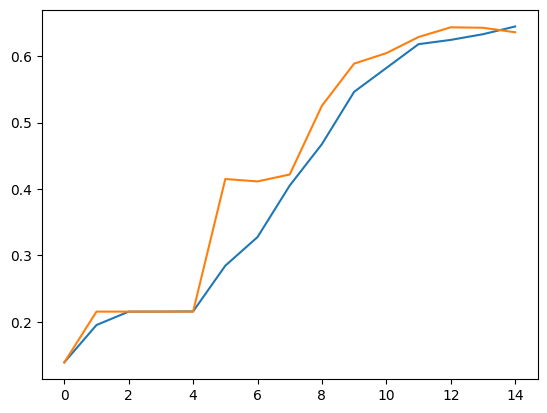

In [105]:
import matplotlib.pyplot as plt

plt.plot(result_f1_train)
plt.plot(result_f1_val)
plt.show()

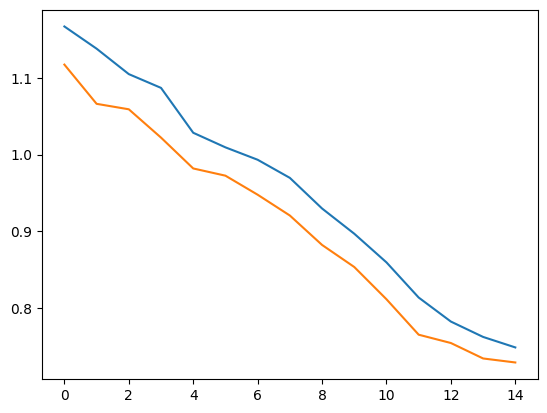

In [106]:
plt.plot(result_loss_train)
plt.plot(result_loss_val)
plt.show()

In [107]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()



10324

поменяем процент трейновый выборки 

In [108]:
x_train,x_test, y_train, y_test =train_test_split(
    X,
    Y,
    random_state=42,
    test_size=0.4,
    stratify=Y
)
x_val,x_test, y_val, y_test =train_test_split(
    x_test,
    y_test,
    random_state=42,
    test_size=0.8,
    stratify=y_test
)
x_train_prep = [token2idx(text) for text in x_train]
x_val_prep = [token2idx(text) for text in x_val]
x_test_prep = [token2idx(text) for text in x_test]
x_train_prep = torch.from_numpy(padding(x_train_prep, 1024))
x_val_prep = torch.from_numpy(padding(x_val_prep, 1024))
x_test_prep = torch.from_numpy(padding(x_test_prep, 1024))
y_train = torch.from_numpy(y_train.to_numpy())
y_val = torch.from_numpy(y_val.to_numpy())
y_test = torch.from_numpy(y_test.to_numpy())

In [110]:
model = Net()
model.to(device)
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
)
criterion = torch.nn.CrossEntropyLoss()

In [111]:


train_dataset = TensorDataset(
    x_train_prep,
    y_train,
)

val_dataset = TensorDataset(
    x_val_prep,
    y_val,
)

test_dataset = TensorDataset(
    x_test_prep,
    y_test
)


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)


val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [ ]:
result_f1_train =[]
result_f1_val =[]
result_loss_train = []
result_loss_val = []
for epoch in range(epochs):
    avg_loss = 0.0
    avg_f1 = []
    softmax = nn.Softmax(dim=1)
    
    model.train()
    
    for i, (x_batch, y_batch) in enumerate(train_loader, 1):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch.long())
        loss = criterion(y_pred, y_batch)
        avg_loss += loss.item()
        avg_f1.append(multiclass_f1_score(softmax(y_pred),y_batch,num_classes=3,average='macro'))
        loss.backward()
        optimizer.step()
    
    result_loss_train.append(avg_loss / (len(train_loader.dataset) // batch_size))
    result_f1_train.append(sum(avg_f1)/len(avg_f1))
    avg_f1=[]
    print(
        f"[Epoch {epoch + 1}] [Train] loss: {result_loss_train[-1]:.3f} f1: {result_f1_train[-1]:.3f}",
        end= " "
    )

    model.eval()

    avg_val_loss = .0

    for i, (x_batch, y_batch) in enumerate(val_loader, 1):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch.long())
        loss = criterion(y_pred, y_batch)
        avg_f1.append(multiclass_f1_score(softmax(y_pred),y_batch,num_classes=3,average='macro'))

        avg_val_loss += loss.item()
    result_loss_val.append(avg_val_loss / (len(val_loader.dataset) // batch_size))
    result_f1_val.append(sum(avg_f1)/len(avg_f1))
    avg_f1=[]
    print(
        f"[Val] loss: {result_loss_val[-1]:.3f} f1: {result_f1_val[-1]:.3f}"
    )

[Epoch 1] [Train] loss: 0.938 f1: 0.349 [Val] loss: 0.739 f1: 0.645
[Epoch 2] [Train] loss: 0.682 f1: 0.657 [Val] loss: 0.662 f1: 0.667
[Epoch 3] [Train] loss: 0.637 f1: 0.681 [Val] loss: 0.635 f1: 0.690
[Epoch 4] [Train] loss: 0.612 f1: 0.695 [Val] loss: 0.622 f1: 0.705
[Epoch 5] [Train] loss: 0.593 f1: 0.707 [Val] loss: 0.602 f1: 0.718
[Epoch 6] [Train] loss: 0.578 f1: 0.715 [Val] loss: 0.591 f1: 0.719
[Epoch 7] [Train] loss: 0.567 f1: 0.721 [Val] loss: 0.586 f1: 0.727
[Epoch 8] [Train] loss: 0.557 f1: 0.727 [Val] loss: 0.566 f1: 0.730
[Epoch 9] [Train] loss: 0.548 f1: 0.733 [Val] loss: 0.564 f1: 0.731
[Epoch 10] [Train] loss: 0.546 f1: 0.733 [Val] loss: 0.559 f1: 0.732
[Epoch 11] [Train] loss: 0.535 f1: 0.740 [Val] loss: 0.552 f1: 0.735
[Epoch 12] [Train] loss: 0.527 f1: 0.744 [Val] loss: 0.555 f1: 0.742
[Epoch 13] [Train] loss: 0.521 f1: 0.748 [Val] loss: 0.553 f1: 0.746


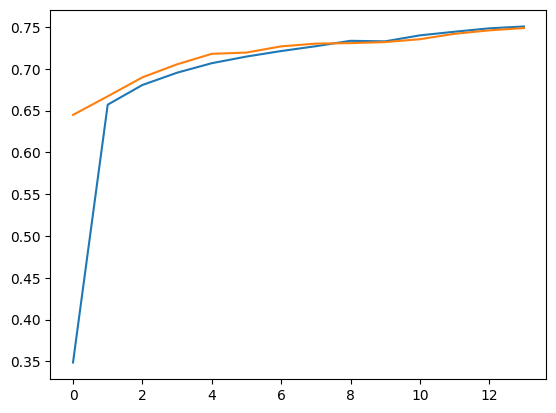

In [114]:
result_f1_train =list(map(lambda x: x.detach().cpu(),result_f1_train))
result_f1_val =list(map(lambda x: x.detach().cpu(),result_f1_val))
plt.plot(result_f1_train)
plt.plot(result_f1_val)
plt.show()

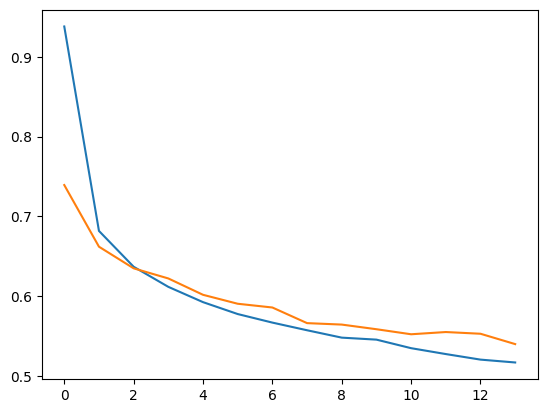

In [115]:
plt.plot(result_loss_train)
plt.plot(result_loss_val)
plt.show()

In [117]:
avg_f1=[]
model.eval()

for (x_batch, y_batch) in test_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_pred = model(x_batch.long())
    avg_f1.append(multiclass_f1_score(softmax(y_pred),y_batch,num_classes=3,average='macro'))


metrics_test['NavecEmbedding+LSTM'] = sum(avg_f1)/len(avg_f1), {
    "epoch": 15,
    "batch": 512,
    "train_size": 0.6
}
metrics_test['NavecEmbedding+LSTM']

(tensor(0.7420, device='cuda:0'),
 {'epoch': 15, 'batch': 512, 'train_size': 0.6})

In [119]:
for key, f1 in metrics_test.items():
    print(key,f1[0])

GaussianNB 0.5783193028307135
SVC 0.6576758385416883
NavecEmbedding+LSTM tensor(0.7420, device='cuda:0')


для улучшения результатов можно воспользоваться huggingface моделями и попробовать разный препроцессинг и другие эммбединги